In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii
import pandas as pd
import astropy.io.fits as pyfits
import re
import os
import sys
sys.path.append('/Users/armna254/Documents/GitHub/DCBH-Codes2/Codes')
import default_rcparams
from dcbh_functions import *


%matplotlib inline

In [4]:
#--Find the relevant data file
data_directory = '/Users/armna254/Documents/Data/DAWN-DJA'
apcorrected_fits_file = [file for file in os.listdir(data_directory) if file.endswith('phot_apcorr.fits')]
apcorrected_fits_file

['gds-grizli-v7.0-fix_phot_apcorr.fits',
 'gdn-grizli-v7.0-fix_phot_apcorr.fits']

In [19]:
phot_data = apcorrected_fits_file[1]
data_path = os.path.join(data_directory, phot_data)
phot_data = data_path
phot_data

'/Users/armna254/Documents/Data/DAWN-DJA/gdn-grizli-v7.0-fix_phot_apcorr.fits'

In [7]:
#--Path to the model file
model_file = '/Users/armna\254/Documents/Data/Pacucci-Model/JWST_NIRCam_ABmag_Pacucci16_SED_5e5to7e6M_z5to15_deltaz0.1_67_0.32_0.68_Lyaabs.dat'

In [13]:

data = pyfits.open(data_path)#[1].data
data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4086 / length of dimension 1                          
NAXIS2  =                37890 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  553 / number of table fields                         
TTYPE1  = 'id      '                                                            
TFORM1  = 'J       '                                                            
TNULL1  =               999999                                                  
TTYPE2  = 'thresh  '                                                            
TFORM2  = 'D       '        

In [14]:
required_filters = ['f105w', 'f110w', 'f115w', 'f125w', 'f140w', 'f150w', 'f160w', 'f182m','f356w', 'f435w', 'f444w', 'f606w', 'f775w', 'f814w']


In [20]:
# Define the data_extract function
def data_extract(datafile, kind, ekind, aper, required_filters):
    data = pyfits.open(datafile)[1].data
    
    id = data['id'].byteswap().newbyteorder()
    ra = data['ra'].byteswap().newbyteorder()
    dec = data['dec'].byteswap().newbyteorder()

    # Convert structured array to DataFrame
    data_df = pd.DataFrame(data)

    f_data = {}
    ef_data = {}
    
    for filter_name in required_filters:
        f_column_name = f"{filter_name}_{kind}_{aper}"
        ef_column_name = f"{filter_name}_{ekind}_{aper}"

        # Check the byte order of the column and handle accordingly
        if f_column_name in data_df.columns:
            if data_df[f_column_name].dtype.byteorder == '>':
                f_data[filter_name] = data_df[f_column_name].values.byteswap().newbyteorder()
            else:
                f_data[filter_name] = data_df[f_column_name].values
        if ef_column_name in data_df.columns:
            if data_df[ef_column_name].dtype.byteorder == '>':
                ef_data[filter_name] = data_df[ef_column_name].values.byteswap().newbyteorder()
            else:
                ef_data[filter_name] = data_df[ef_column_name].values

    dataframe_dict = {'ID': id, 'RA(deg)': ra, 'Dec(deg)': dec}
    dataframe_dict.update({f'{key.upper()}': value for key, value in f_data.items()})
    dataframe_dict.update({f'e{key.upper()}': value for key, value in ef_data.items()})
    
    dataframe = pd.DataFrame(dataframe_dict)
    dataframe = dataframe.replace(-99.0, np.nan)

    return dataframe

In [21]:
data_photometry = data_extract(phot_data, kind='corr', ekind='ecorr', aper='0', required_filters=required_filters)


In [24]:
data_photometry

,ID,RA(deg),Dec(deg),F105W,F110W,F115W,F125W,F140W,F150W,F160W,...,eF140W,eF150W,eF160W,eF182M,eF356W,eF435W,eF444W,eF606W,eF775W,eF814W
0,1,189.389409,62.150175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,189.231767,62.150306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,189.203387,62.150311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,189.187190,62.150311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,189.138625,62.150300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37885,37886,189.222065,62.335594,0.060013,NaN,NaN,0.041356,0.075056,NaN,0.040805,...,0.025841,NaN,0.010243,0.026200,NaN,0.002959,0.013025,0.004250,0.003665,0.003602
37886,37887,189.228093,62.335966,-0.000635,NaN,NaN,0.025738,0.015838,NaN,-0.000010,...,0.016735,NaN,0.008362,0.006671,NaN,0.001930,0.008430,0.002792,0.002317,0.002363
37887,37888,189.221817,62.336519,0.037415,NaN,NaN,0.057713,0.069521,NaN,0.089319,...,0.016817,NaN,0.008767,0.014553,NaN,0.001980,NaN,0.002839,0.002328,0.002321
37888,37889,189.222303,62.337034,0.056634,NaN,NaN,0.035540,0.038030,NaN,0.045375,...,0.017994,NaN,0.010369,0.015652,NaN,0.002075,NaN,0.002859,0.002480,0.002540


In [ ]:
# Convert byte order of columns in data_photometry_1 and data_photometry_2
for col in data_photometry_1.columns:
    if data_photometry_1[col].dtype.byteorder == '>':
        data_photometry_1[col] = data_photometry_1[col].values.byteswap().newbyteorder()
        
for col in data_photometry_2.columns:
    if data_photometry_2[col].dtype.byteorder == '>':
        data_photometry_2[col] = data_photometry_2[col].values.byteswap().newbyteorder()

# Merge the two dataframes based on 'ID', 'RA(deg)', and 'Dec(deg)'
merged_data_photometry = pd.merge(data_photometry_1, data_photometry_2, on=['ID', 'RA(deg)', 'Dec(deg)'], how='outer')


In [ ]:
#data_photometry = data_extract1(phot_data, kind='flux_aper', ekind='fluxerr_aper', aper = '0')
#data_photometry1 = data_extract1(phot_data, kind='corr', ekind='ecorr', aper = '0')
#data_photometry = data_extract1(phot_data, kind='tot', ekind='etot', aper = '0')


In [ ]:
data_photometry.head()
data_photometry.max()


ID          37890.000000
RA(deg)       189.403004
Dec(deg)       62.338228
f105w       19742.113663
f110w         125.388263
f115w         283.687031
f125w       20981.794740
f140w       21995.177161
f150w         359.230539
f160w       21206.475330
f182m         500.513522
f356w         158.640973
f435w        1165.319781
f444w         525.061600
f606w         705.083351
f775w        2539.113873
f814w        2101.200284
ef105w          7.399570
ef110w          0.425591
ef115w          0.465650
ef125w          1.597986
ef140w         16.872505
ef150w          0.430349
ef160w          1.344694
ef182m          0.811998
ef356w          0.369719
ef435w          0.424836
ef444w          9.333868
ef606w          1.013711
ef775w          0.706181
ef814w          0.507911
dtype: float64

In [ ]:
#--If you want the editor show more lines of the data
#pd.set_option('display.max_rows', df1.shape[0]+1)
pd.set_option('display.max_columns', data_photometry.shape[1]+1)

In [ ]:
# Drop rows where all selected columns have NaN
data_photometry_filtered = data_photometry.dropna(subset=['F150W','F444W'], how='any')
data_photometry_filtered = data_photometry_filtered.astype(float)

In [ ]:
data_photometry_filtered

,ID,RA(deg),Dec(deg),F105W,F110W,F115W,F125W,F140W,F150W,F160W,...,eF140W,eF150W,eF160W,eF182M,eF356W,eF435W,eF444W,eF606W,eF775W,eF814W
9,10.0,189.360523,62.150222,NaN,NaN,0.026153,NaN,NaN,0.011833,NaN,...,NaN,0.003470,NaN,NaN,0.002087,NaN,0.002684,NaN,0.005691,0.002122
10,11.0,189.358984,62.150220,NaN,NaN,0.009370,NaN,NaN,0.022326,NaN,...,NaN,0.004027,NaN,NaN,0.002611,NaN,0.003571,NaN,0.007277,0.002568
11,12.0,189.349279,62.150236,NaN,NaN,0.033112,NaN,NaN,0.044073,NaN,...,NaN,0.004230,NaN,NaN,0.002740,0.003109,0.006456,NaN,0.007600,0.002740
12,13.0,189.377417,62.150207,NaN,NaN,0.063839,NaN,NaN,0.116221,NaN,...,NaN,-188.569991,NaN,NaN,-188.577954,NaN,-188.595212,NaN,0.008858,0.003202
13,14.0,189.307108,62.150294,NaN,NaN,0.013358,0.008230,NaN,0.020188,0.007444,...,NaN,0.002788,0.006256,NaN,0.001725,0.001737,0.002481,NaN,0.004795,0.001896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36334,36335.0,189.371397,62.307834,1.432552,NaN,2.160555,1.728114,1.850873,2.681946,1.987718,...,0.064494,0.012359,0.035743,NaN,0.010894,0.007724,0.011376,0.010473,0.014240,0.013223
36335,36336.0,189.371737,62.308042,0.242134,NaN,0.431334,0.364519,0.332764,0.530072,0.310140,...,0.042057,0.008191,0.023114,NaN,0.005595,0.005637,0.007414,0.006824,0.009520,0.008336
36342,36343.0,189.379366,62.308191,0.177592,NaN,0.243300,0.212822,0.201394,0.254866,0.238766,...,0.041847,0.008685,0.022173,NaN,-268.629889,0.006810,0.014432,0.006880,0.009581,0.007182
36376,36377.0,189.369403,62.308490,-0.004176,NaN,0.201868,0.039915,0.101672,0.182044,0.047778,...,0.045013,0.008062,0.021495,NaN,0.008416,0.005090,0.011557,0.006394,0.009530,0.007992


In [ ]:
data_photometry_filtered.shape

(9430, 31)

In [ ]:
L1 = []  # List for filters
L2 = []  # List for errors

for col in data_photometry_filtered.columns:
    if col.startswith('F'):
        L1.append(col)
    elif col.startswith('e'):
        L2.append(col)

print("Filters:", L1)
print("Errors:", L2)

Filters: ['F105W', 'F110W', 'F115W', 'F125W', 'F140W', 'F150W', 'F160W', 'F182M', 'F356W', 'F435W', 'F444W', 'F606W', 'F775W', 'F814W']
Errors: ['eF105W', 'eF110W', 'eF115W', 'eF125W', 'eF140W', 'eF150W', 'eF160W', 'eF182M', 'eF356W', 'eF435W', 'eF444W', 'eF606W', 'eF775W', 'eF814W']


In [ ]:
List1 = ['F150W', 'F444W']
List2 = ['eF150W', 'eF444W']

# Number of columns in L1 and L2
num_l1_columns = len(List1)
num_l2_columns = len(List2)

# Create a list of conditions for each pair of L1/L2 columns
conditions = []
for i in range(num_l1_columns):
    l1_col = List1[i]
    l2_col = List2[i]
    condition = (data_photometry_filtered[l2_col] / data_photometry_filtered[l1_col]) < 0.2    #signal to noise ratio
    conditions.append(condition)

# Combine the conditions using the logical AND operator
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition = combined_condition & condition

# Filter rows based on the combined condition
data_photometry_filtered = data_photometry_filtered[combined_condition]

In [ ]:
data_photometry_filtered

,ID,RA(deg),Dec(deg),F090W,F115W,F150W,F200W,F277W,F356W,F410M,F444W,eF090W,eF115W,eF150W,eF200W,eF277W,eF356W,eF410M,eF444W
5872,5873.0,53.170840,-27.846683,NaN,0.056670,0.058126,0.068538,0.067090,0.058300,0.052145,0.044827,NaN,0.001461,0.001679,0.001447,0.001432,0.001350,0.002370,0.001859
5985,5986.0,53.172653,-27.846376,NaN,0.318076,0.571733,0.836093,NaN,NaN,NaN,1.945321,NaN,0.005431,0.006654,0.006112,NaN,NaN,NaN,0.014344
5997,5998.0,53.171592,-27.846234,NaN,0.039660,0.040132,0.040183,0.033465,0.023567,0.020164,0.019260,NaN,0.001340,0.001547,0.001304,0.001029,0.001012,0.001678,0.001355
6101,6102.0,53.168983,-27.845813,NaN,0.015958,0.021523,0.032447,0.022727,0.015727,0.017628,0.018555,NaN,0.001358,0.001615,0.001344,0.001314,0.001332,0.002177,0.001703
6125,6126.0,53.172159,-27.845693,NaN,0.010407,0.009091,0.016346,0.014593,0.012113,0.014451,0.011255,NaN,0.001053,0.001243,0.001047,0.000865,0.000826,0.001491,0.001203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52409,52410.0,53.158264,-27.724959,0.010760,0.016594,0.015040,0.017138,0.012517,0.011994,0.010593,0.010028,0.001286,0.001066,0.001130,0.001301,0.000771,0.000961,0.001216,0.001080
52410,52411.0,53.157882,-27.725303,0.014821,0.017091,0.020420,0.046004,0.037634,0.038224,0.034282,0.038720,0.001904,0.001577,0.001670,0.001971,0.001345,0.001732,0.002114,0.001925
52411,52412.0,53.157930,-27.725122,0.145826,0.176116,0.239428,0.441463,0.424956,0.387550,0.458411,0.460577,0.002333,0.002112,0.002319,0.002895,0.002420,0.002545,0.002983,0.002782
52414,52415.0,53.157549,-27.724746,0.072741,0.073980,0.096903,0.123385,0.063484,0.065454,0.064462,0.057862,0.001389,0.001206,0.001313,0.001495,0.000921,0.001069,0.001302,0.001146


In [ ]:
for i, j in zip(L1, L2):
    data_photometry_filtered[f'{i}_up'] = data_photometry_filtered[i] + data_photometry_filtered[j]
    data_photometry_filtered[f'{i}_lo'] = data_photometry_filtered[i] - data_photometry_filtered[j]

/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082/3899251412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered[f'{i}_up'] = data_photometry_filtered[i] + data_photometry_filtered[j]
/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082/3899251412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered[f'{i}_lo'] = data_photometry_filtered[i] - data_photometry_filtered[j]
/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082

In [ ]:

data_photometry_filtered_AB = data_photometry_filtered
exclude_cols = ['ID', 'RA(deg)', 'Dec(deg)']
selected_cols = [col for col in data_photometry_filtered_AB.columns if col not in exclude_cols]
data_photometry_filtered_AB[selected_cols] = convert_to_ab(data_photometry_filtered_AB[selected_cols])
data_photometry_filtered_AB

/Users/armna254/miniconda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082/681230526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered_AB[selected_cols] = convert_to_ab(data_photometry_filtered_AB[selected_cols])


,ID,RA(deg),Dec(deg),F105W,F110W,F115W,F125W,F140W,F150W,F160W,...,F435W_up,F435W_lo,F444W_up,F444W_lo,F606W_up,F606W_lo,F775W_up,F775W_lo,F814W_up,F814W_lo
11,12.0,189.349279,62.150236,NaN,NaN,27.600101,NaN,NaN,27.289643,NaN,...,28.221862,28.661517,27.402176,27.828898,NaN,NaN,27.365552,27.866973,28.045842,28.357466
12,13.0,189.377417,62.150207,NaN,NaN,26.887343,NaN,NaN,26.236859,NaN,...,NaN,NaN,NaN,18.210410,NaN,NaN,26.731420,27.029930,26.773368,26.876132
13,14.0,189.307108,62.150294,NaN,NaN,28.585718,29.111504,NaN,28.137310,29.220477,...,29.438340,30.355709,28.362992,28.754232,NaN,NaN,28.620969,30.090160,28.991635,29.569367
14,15.0,189.329336,62.150261,NaN,NaN,25.293536,NaN,NaN,25.417924,NaN,...,26.520691,26.593958,25.182668,25.209349,NaN,NaN,26.113994,26.238048,26.079643,26.122531
16,17.0,189.310364,62.150275,NaN,NaN,27.521734,27.368763,NaN,27.308687,27.414741,...,30.319994,NaN,27.062316,27.230256,NaN,NaN,27.040435,27.454669,27.428514,27.627822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36329,36330.0,189.383526,62.308077,27.310756,NaN,26.880519,27.260535,NaN,26.757854,27.585370,...,27.613858,27.919539,NaN,18.361628,27.261345,27.488933,27.251482,27.546332,27.268158,27.525675
36334,36335.0,189.371397,62.307834,23.509789,NaN,23.063652,23.306134,23.231624,22.828940,23.154178,...,25.257873,25.318087,22.642315,22.650098,24.624117,24.669353,23.825046,23.854294,23.675334,23.698934
36335,36336.0,189.371737,62.308042,25.439925,NaN,24.813031,24.995765,25.094726,24.589228,25.171171,...,25.999464,26.087576,24.785706,24.822728,25.820056,25.910576,25.724594,25.841649,25.761512,25.867002
36342,36343.0,189.379366,62.308191,25.776505,NaN,25.434711,25.580025,25.639952,25.384284,25.455134,...,27.021243,27.321152,25.113148,25.213425,26.624689,26.825967,26.013242,26.169682,25.993764,26.106706


In [ ]:
for i, j in zip(L1, L2):
    # Create a new column f'{i}_fin' based on the comparison
    data_photometry_filtered_AB[f'{i}_fin'] = data_photometry_filtered_AB[[f'{i}_up', f'{i}_lo']].max(axis=1)
    data_photometry_filtered_AB[j] = data_photometry_filtered_AB[f'{i}_fin'] - data_photometry_filtered_AB[i]
data_photometry_filtered_AB

/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082/4146240880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered_AB[f'{i}_fin'] = data_photometry_filtered_AB[[f'{i}_up', f'{i}_lo']].max(axis=1)
/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082/4146240880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered_AB[j] = data_photometry_filtered_AB[f'{i}_fin'] - data_photometry_filtered_AB[i]
/var/folders/4c/kn228nps28n6q5djhg2n0k540000

,ID,RA(deg),Dec(deg),F105W,F110W,F115W,F125W,F140W,F150W,F160W,...,F140W_fin,F150W_fin,F160W_fin,F182M_fin,F356W_fin,F435W_fin,F444W_fin,F606W_fin,F775W_fin,F814W_fin
11,12.0,189.349279,62.150236,NaN,NaN,27.600101,NaN,NaN,27.289643,NaN,...,NaN,27.399186,NaN,NaN,28.011835,28.661517,27.828898,NaN,27.866973,28.357466
12,13.0,189.377417,62.150207,NaN,NaN,26.887343,NaN,NaN,26.236859,NaN,...,NaN,18.210715,NaN,NaN,18.210426,NaN,18.210410,NaN,27.029930,26.876132
13,14.0,189.307108,62.150294,NaN,NaN,28.585718,29.111504,NaN,28.137310,29.220477,...,NaN,28.298665,31.212375,NaN,28.583084,30.355709,28.754232,NaN,30.090160,29.569367
14,15.0,189.329336,62.150261,NaN,NaN,25.293536,NaN,NaN,25.417924,NaN,...,NaN,25.436358,NaN,NaN,25.329724,26.593958,25.209349,NaN,26.238048,26.122531
16,17.0,189.310364,62.150275,NaN,NaN,27.521734,27.368763,NaN,27.308687,27.414741,...,NaN,27.438866,27.810793,NaN,27.105188,30.319994,27.230256,NaN,27.454669,27.627822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36329,36330.0,189.383526,62.308077,27.310756,NaN,26.880519,27.260535,NaN,26.757854,27.585370,...,NaN,26.834450,28.121872,NaN,NaN,27.919539,18.361628,27.488933,27.546332,27.525675
36334,36335.0,189.371397,62.307834,23.509789,NaN,23.063652,23.306134,23.231624,22.828940,23.154178,...,23.270131,22.833955,23.173880,NaN,22.339142,25.318087,22.650098,24.669353,23.854294,23.698934
36335,36336.0,189.371737,62.308042,25.439925,NaN,24.813031,24.995765,25.094726,24.589228,25.171171,...,25.241428,24.606137,25.255262,NaN,24.797056,26.087576,24.822728,25.910576,25.841649,25.867002
36342,36343.0,189.379366,62.308191,25.776505,NaN,25.434711,25.580025,25.639952,25.384284,25.455134,...,25.892849,25.421929,25.560954,NaN,17.825849,27.321152,25.213425,26.825967,26.169682,26.106706


In [ ]:
data_photometry_filtered_AB.columns

Index(['ID', 'RA(deg)', 'Dec(deg)', 'F105W', 'F110W', 'F115W', 'F125W',
       'F140W', 'F150W', 'F160W', 'F182M', 'F356W', 'F435W', 'F444W', 'F606W',
       'F775W', 'F814W', 'eF105W', 'eF110W', 'eF115W', 'eF125W', 'eF140W',
       'eF150W', 'eF160W', 'eF182M', 'eF356W', 'eF435W', 'eF444W', 'eF606W',
       'eF775W', 'eF814W', 'F105W_up', 'F105W_lo', 'F110W_up', 'F110W_lo',
       'F115W_up', 'F115W_lo', 'F125W_up', 'F125W_lo', 'F140W_up', 'F140W_lo',
       'F150W_up', 'F150W_lo', 'F160W_up', 'F160W_lo', 'F182M_up', 'F182M_lo',
       'F356W_up', 'F356W_lo', 'F435W_up', 'F435W_lo', 'F444W_up', 'F444W_lo',
       'F606W_up', 'F606W_lo', 'F775W_up', 'F775W_lo', 'F814W_up', 'F814W_lo',
       'F105W_fin', 'F110W_fin', 'F115W_fin', 'F125W_fin', 'F140W_fin',
       'F150W_fin', 'F160W_fin', 'F182M_fin', 'F356W_fin', 'F435W_fin',
       'F444W_fin', 'F606W_fin', 'F775W_fin', 'F814W_fin'],
      dtype='object')

In [ ]:
columns_to_drop = [col for col in data_photometry_filtered_AB.columns if '_lo' in col or '_up' in col or '_fin' in col]
data_photometry_filtered_AB.drop(columns = columns_to_drop, axis=1, inplace=True)
data_photometry_filtered_AB

/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082/3733435285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered_AB.drop(columns = columns_to_drop, axis=1, inplace=True)


,ID,RA(deg),Dec(deg),F105W,F110W,F115W,F125W,F140W,F150W,F160W,...,eF140W,eF150W,eF160W,eF182M,eF356W,eF435W,eF444W,eF606W,eF775W,eF814W
11,12.0,189.349279,62.150236,NaN,NaN,27.600101,NaN,NaN,27.289643,NaN,...,NaN,0.109543,NaN,NaN,0.123939,0.241931,0.234191,NaN,0.279403,0.166954
12,13.0,189.377417,62.150207,NaN,NaN,26.887343,NaN,NaN,26.236859,NaN,...,NaN,-8.026143,NaN,NaN,-7.689498,NaN,-7.793582,NaN,0.159482,0.052598
13,14.0,189.307108,62.150294,NaN,NaN,28.585718,29.111504,NaN,28.137310,29.220477,...,NaN,0.161355,1.991898,NaN,0.131531,0.552821,0.213148,NaN,0.966179,0.326849
14,15.0,189.329336,62.150261,NaN,NaN,25.293536,NaN,NaN,25.417924,NaN,...,NaN,0.018433,NaN,NaN,0.014570,0.037252,0.013422,NaN,0.063797,0.021656
16,17.0,189.310364,62.150275,NaN,NaN,27.521734,27.368763,NaN,27.308687,27.414741,...,NaN,0.130179,0.396052,NaN,0.060518,NaN,0.087214,NaN,0.226753,0.104221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36329,36330.0,189.383526,62.308077,27.310756,NaN,26.880519,27.260535,NaN,26.757854,27.585370,...,NaN,0.076596,0.536502,NaN,NaN,0.163563,-8.695210,0.119746,0.157403,0.136376
36334,36335.0,189.371397,62.307834,23.509789,NaN,23.063652,23.306134,23.231624,22.828940,23.154178,...,0.038507,0.005015,0.019701,NaN,0.002805,0.030524,0.003899,0.022853,0.014723,0.011864
36335,36336.0,189.371737,62.308042,25.439925,NaN,24.813031,24.995765,25.094726,24.589228,25.171171,...,0.146702,0.016909,0.084091,NaN,0.013789,0.044950,0.018669,0.046203,0.060105,0.054026
36342,36343.0,189.379366,62.308191,25.776505,NaN,25.434711,25.580025,25.639952,25.384284,25.455134,...,0.252897,0.037645,0.105820,NaN,-7.280067,0.160277,0.051296,0.105296,0.081035,0.057939


In [ ]:
data_photometry_filtered_AB['eF150W'].min()

-11.414844376644691

In [ ]:
data_photometry_filtered_AB['F150W-F444W'] = data_photometry_filtered_AB['F150W'] - data_photometry_filtered_AB['F444W']
data_photometry_filtered_AB

/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_50082/3740966893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered_AB['F150W-F444W'] = data_photometry_filtered_AB['F150W'] - data_photometry_filtered_AB['F444W']


,ID,RA(deg),Dec(deg),F105W,F110W,F115W,F125W,F140W,F150W,F160W,...,eF150W,eF160W,eF182M,eF356W,eF435W,eF444W,eF606W,eF775W,eF814W,F150W-F444W
11,12.0,189.349279,62.150236,NaN,NaN,27.600101,NaN,NaN,27.289643,NaN,...,0.109543,NaN,NaN,0.123939,0.241931,0.234191,NaN,0.279403,0.166954,-0.305064
12,13.0,189.377417,62.150207,NaN,NaN,26.887343,NaN,NaN,26.236859,NaN,...,-8.026143,NaN,NaN,-7.689498,NaN,-7.793582,NaN,0.159482,0.052598,0.232866
13,14.0,189.307108,62.150294,NaN,NaN,28.585718,29.111504,NaN,28.137310,29.220477,...,0.161355,1.991898,NaN,0.131531,0.552821,0.213148,NaN,0.966179,0.326849,-0.403774
14,15.0,189.329336,62.150261,NaN,NaN,25.293536,NaN,NaN,25.417924,NaN,...,0.018433,NaN,NaN,0.014570,0.037252,0.013422,NaN,0.063797,0.021656,0.221998
16,17.0,189.310364,62.150275,NaN,NaN,27.521734,27.368763,NaN,27.308687,27.414741,...,0.130179,0.396052,NaN,0.060518,NaN,0.087214,NaN,0.226753,0.104221,0.165645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36329,36330.0,189.383526,62.308077,27.310756,NaN,26.880519,27.260535,NaN,26.757854,27.585370,...,0.076596,0.536502,NaN,NaN,0.163563,-8.695210,0.119746,0.157403,0.136376,-0.298984
36334,36335.0,189.371397,62.307834,23.509789,NaN,23.063652,23.306134,23.231624,22.828940,23.154178,...,0.005015,0.019701,NaN,0.002805,0.030524,0.003899,0.022853,0.014723,0.011864,0.182741
36335,36336.0,189.371737,62.308042,25.439925,NaN,24.813031,24.995765,25.094726,24.589228,25.171171,...,0.016909,0.084091,NaN,0.013789,0.044950,0.018669,0.046203,0.060105,0.054026,-0.214830
36342,36343.0,189.379366,62.308191,25.776505,NaN,25.434711,25.580025,25.639952,25.384284,25.455134,...,0.037645,0.105820,NaN,-7.280067,0.160277,0.051296,0.105296,0.081035,0.057939,0.222155


In [ ]:
data_photometry_filtered_AB_PEB = data_photometry_filtered_AB[~(data_photometry_filtered_AB[L2] < 0).any(axis=1)] 

In [ ]:
data_photometry_filtered_AB_PEB.to_csv(os.path.join(os.getcwd(), 'DAWN_GOODS-N_ABmag_v2.csv'), index=False)

In [ ]:
os.getcwd()

'/Users/armna254/Documents/Data/DAWN-DJA'

In [ ]:
# Define the threshold for large errors
error_threshold = 0.2

# Drop rows where 'error_column' exceeds the threshold
data_photometry_filtered_AB_PEB = data_photometry_filtered_AB_PEB[data_photometry_filtered_AB_PEB['eF444W'] <= error_threshold]
F444_27_31 = data_photometry_filtered_AB_PEB[(data_photometry_filtered_AB_PEB['F444W'] > 27) & (data_photometry_filtered_AB_PEB['F444W'] < 31)]
red_object = F444_27_31[F444_27_31['F150W-F444W'] > 0]


In [ ]:
data_photometry_filtered_AB_PEB.shape[0]

4470

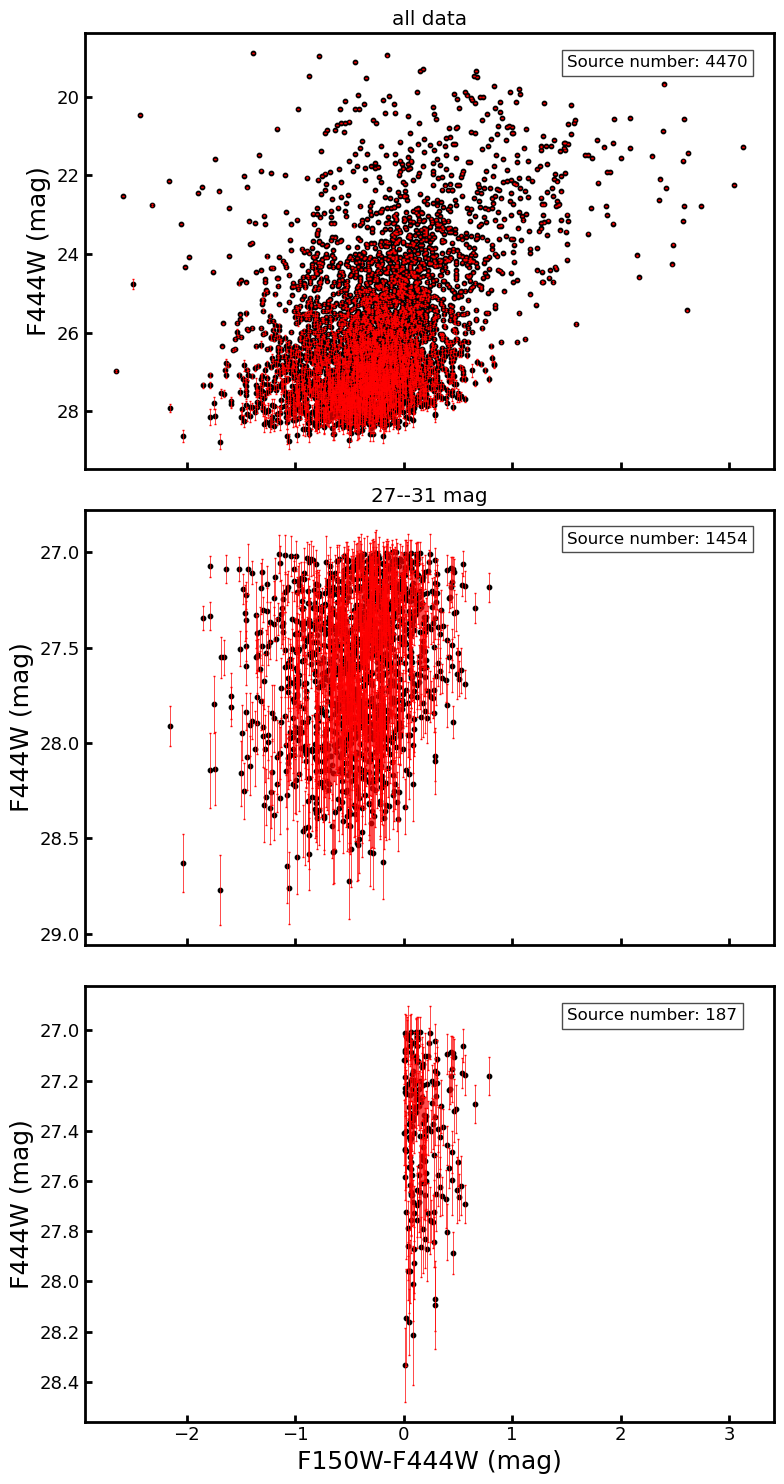

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex = True, figsize=(8,15))

x_column = 'F150W-F444W'
y_column = 'F444W'
y_error = 'eF444W'

data1 = data_photometry_filtered_AB_PEB
data2 = F444_27_31
data3 = red_object

ax1.scatter(x=data1[x_column], y=data1[y_column], s=10, c='k')
ax1.errorbar(x=data1[x_column], y=data1[y_column], yerr=data1[y_error], fmt='o', markersize=0, elinewidth=0.5, color='r', capsize=1)

ax1.set_ylabel(y_column+' (mag)')
ax1.invert_yaxis() 
ax1.set_title('all data')
ax1.text(0.7, 0.95, 'Source number: '+str(data_photometry_filtered_AB_PEB.shape[0]), transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))



ax2.scatter(x=data2[x_column], y=data2[y_column], s=10, c='k')
ax2.errorbar(x=data2[x_column], y=data2[y_column], yerr=data2[y_error], fmt='o', markersize=0, elinewidth=0.5, color='r', capsize=1)

ax2.set_ylabel(y_column+' (mag)')
ax2.invert_yaxis()
ax2.set_title('27--31 mag')
ax2.text(0.7, 0.95, 'Source number: '+str(F444_27_31.shape[0]), transform=ax2.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))


ax3.scatter(x=data3[x_column], y=data3[y_column], s=10, c='k')
ax3.errorbar(x=data3[x_column], y=data3[y_column], yerr=data3[y_error], fmt='o', markersize=0, elinewidth=0.5, color='r', capsize=1)

plt.xlabel(x_column+' (mag)')
plt.ylabel(y_column+' (mag)')
plt.gca().invert_yaxis()
ax3.text(0.7, 0.95, 'Source number: '+str(red_object.shape[0]), transform=ax3.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
columns_to_check = ['F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M']#, 'F444W']

# Replace -99.0 with NaN
data_photometry = data_photometry.replace(-99.0, np.nan)

# Drop rows where all selected columns have NaN
data_photometry_filtered = data_photometry.dropna(subset=columns_to_check, how='all')

# If you want to convert NaN back to -99.0 in the filtered data
data_photometry_filtered[columns_to_check] = data_photometry_filtered[columns_to_check].fillna(-99.0)

/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_99066/3711494282.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered[columns_to_check] = data_photometry_filtered[columns_to_check].fillna(-99.0)


/var/folders/4c/kn228nps28n6q5djhg2n0k540000gn/T/ipykernel_2267/2665070980.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_photometry_filtered[columns_to_check] = data_photometry_filtered[columns_to_check].fillna(-99.0)


In [ ]:
df1 = data_photometry_filtered.copy()
md1 = pd.read_csv(model_file, sep=r"\s+")


In [ ]:
#--Converting to float
df1 = df1.astype(float)
md1 = md1.astype(float)


In [ ]:
flux_jwst, flux_jwst_err = choose_filters_obs(df1)


In [ ]:
#--If you want the editor show more lines of the data
pd.set_option('display.max_rows', df1.shape[0]+1)
pd.set_option('display.max_columns', None)


In [ ]:
flux_jwst_err


,eF090W,eF115W,eF150W,eF200W,eF277W,eF356W,eF410M,eF444W
5872,-99.000000,0.001461,0.001679,0.001447,0.001432,0.001350,0.002370,0.001859
5938,-99.000000,0.000964,0.001156,0.000967,0.000712,0.000670,0.001251,0.000998
5985,-99.000000,0.005431,0.006654,0.006112,-99.000000,-99.000000,-99.000000,0.014344
5995,-99.000000,0.001006,0.001212,0.000988,0.000761,0.000720,0.001436,0.001083
5997,-99.000000,0.001340,0.001547,0.001304,0.001029,0.001012,0.001678,0.001355
...,...,...,...,...,...,...,...,...
52422,0.003000,0.003096,0.002705,-99.000000,-137.122703,-99.000000,-137.127520,-137.108751
52423,0.003670,0.003720,0.003196,-99.000000,0.002722,-99.000000,0.004463,0.003839
52424,0.002762,0.002720,0.002413,-99.000000,0.001928,-99.000000,0.002935,0.002505
52425,0.002451,0.002393,0.002109,-99.000000,0.001473,-99.000000,0.002552,0.002140


In [ ]:
# Given microjansky flux values for two filters
flux_filter_2_microjansky = 100.0   # Replace with actual value
flux_filter_4_44_microjansky = 50.0  # Replace with actual value

# Convert zero points from jansky to microjansky
zero_point_filter_2_microjansky = 758.32 * 1e-6  # For 2.0 micrometers
zero_point_filter_4_44_microjansky = 185.77 * 1e-6  # For 4.44 micrometers

# Convert flux to magnitude using zero point
magnitude_filter_2 = -2.5 * np.log10(flux_filter_2_microjansky / zero_point_filter_2_microjansky)
magnitude_filter_4_44 = -2.5 * np.log10(flux_filter_4_44_microjansky / zero_point_filter_4_44_microjansky)

# Calculate color index
color_index = magnitude_filter_2 - magnitude_filter_4_44

print("Color Index:", color_index)